<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Epidemiology 104</h1>
<h1>Impact of Seasonal effects and the lockdown on CoVID19</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.basemap import Basemap

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

from EpiModel import *

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

numpy      1.18.1
matplotlib 3.1.3
networkx   2.4
json       2.0.9
watermark  2.0.2
autopep8   1.5
scipy      1.4.1
pandas     1.0.1
Sat May 09 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.4.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : dc973ba5b9de06f9c77bd3c7d27e49b10ec03ca1


Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Seasonality

In [4]:
def seasonality(a_max=1.1, a_min=0.1, t_max=15):
    t = np.arange(1, 366)
    return a_min+1/2*(1+np.cos(2*np.pi/365*(t-t_max)))*(a_max-a_min)

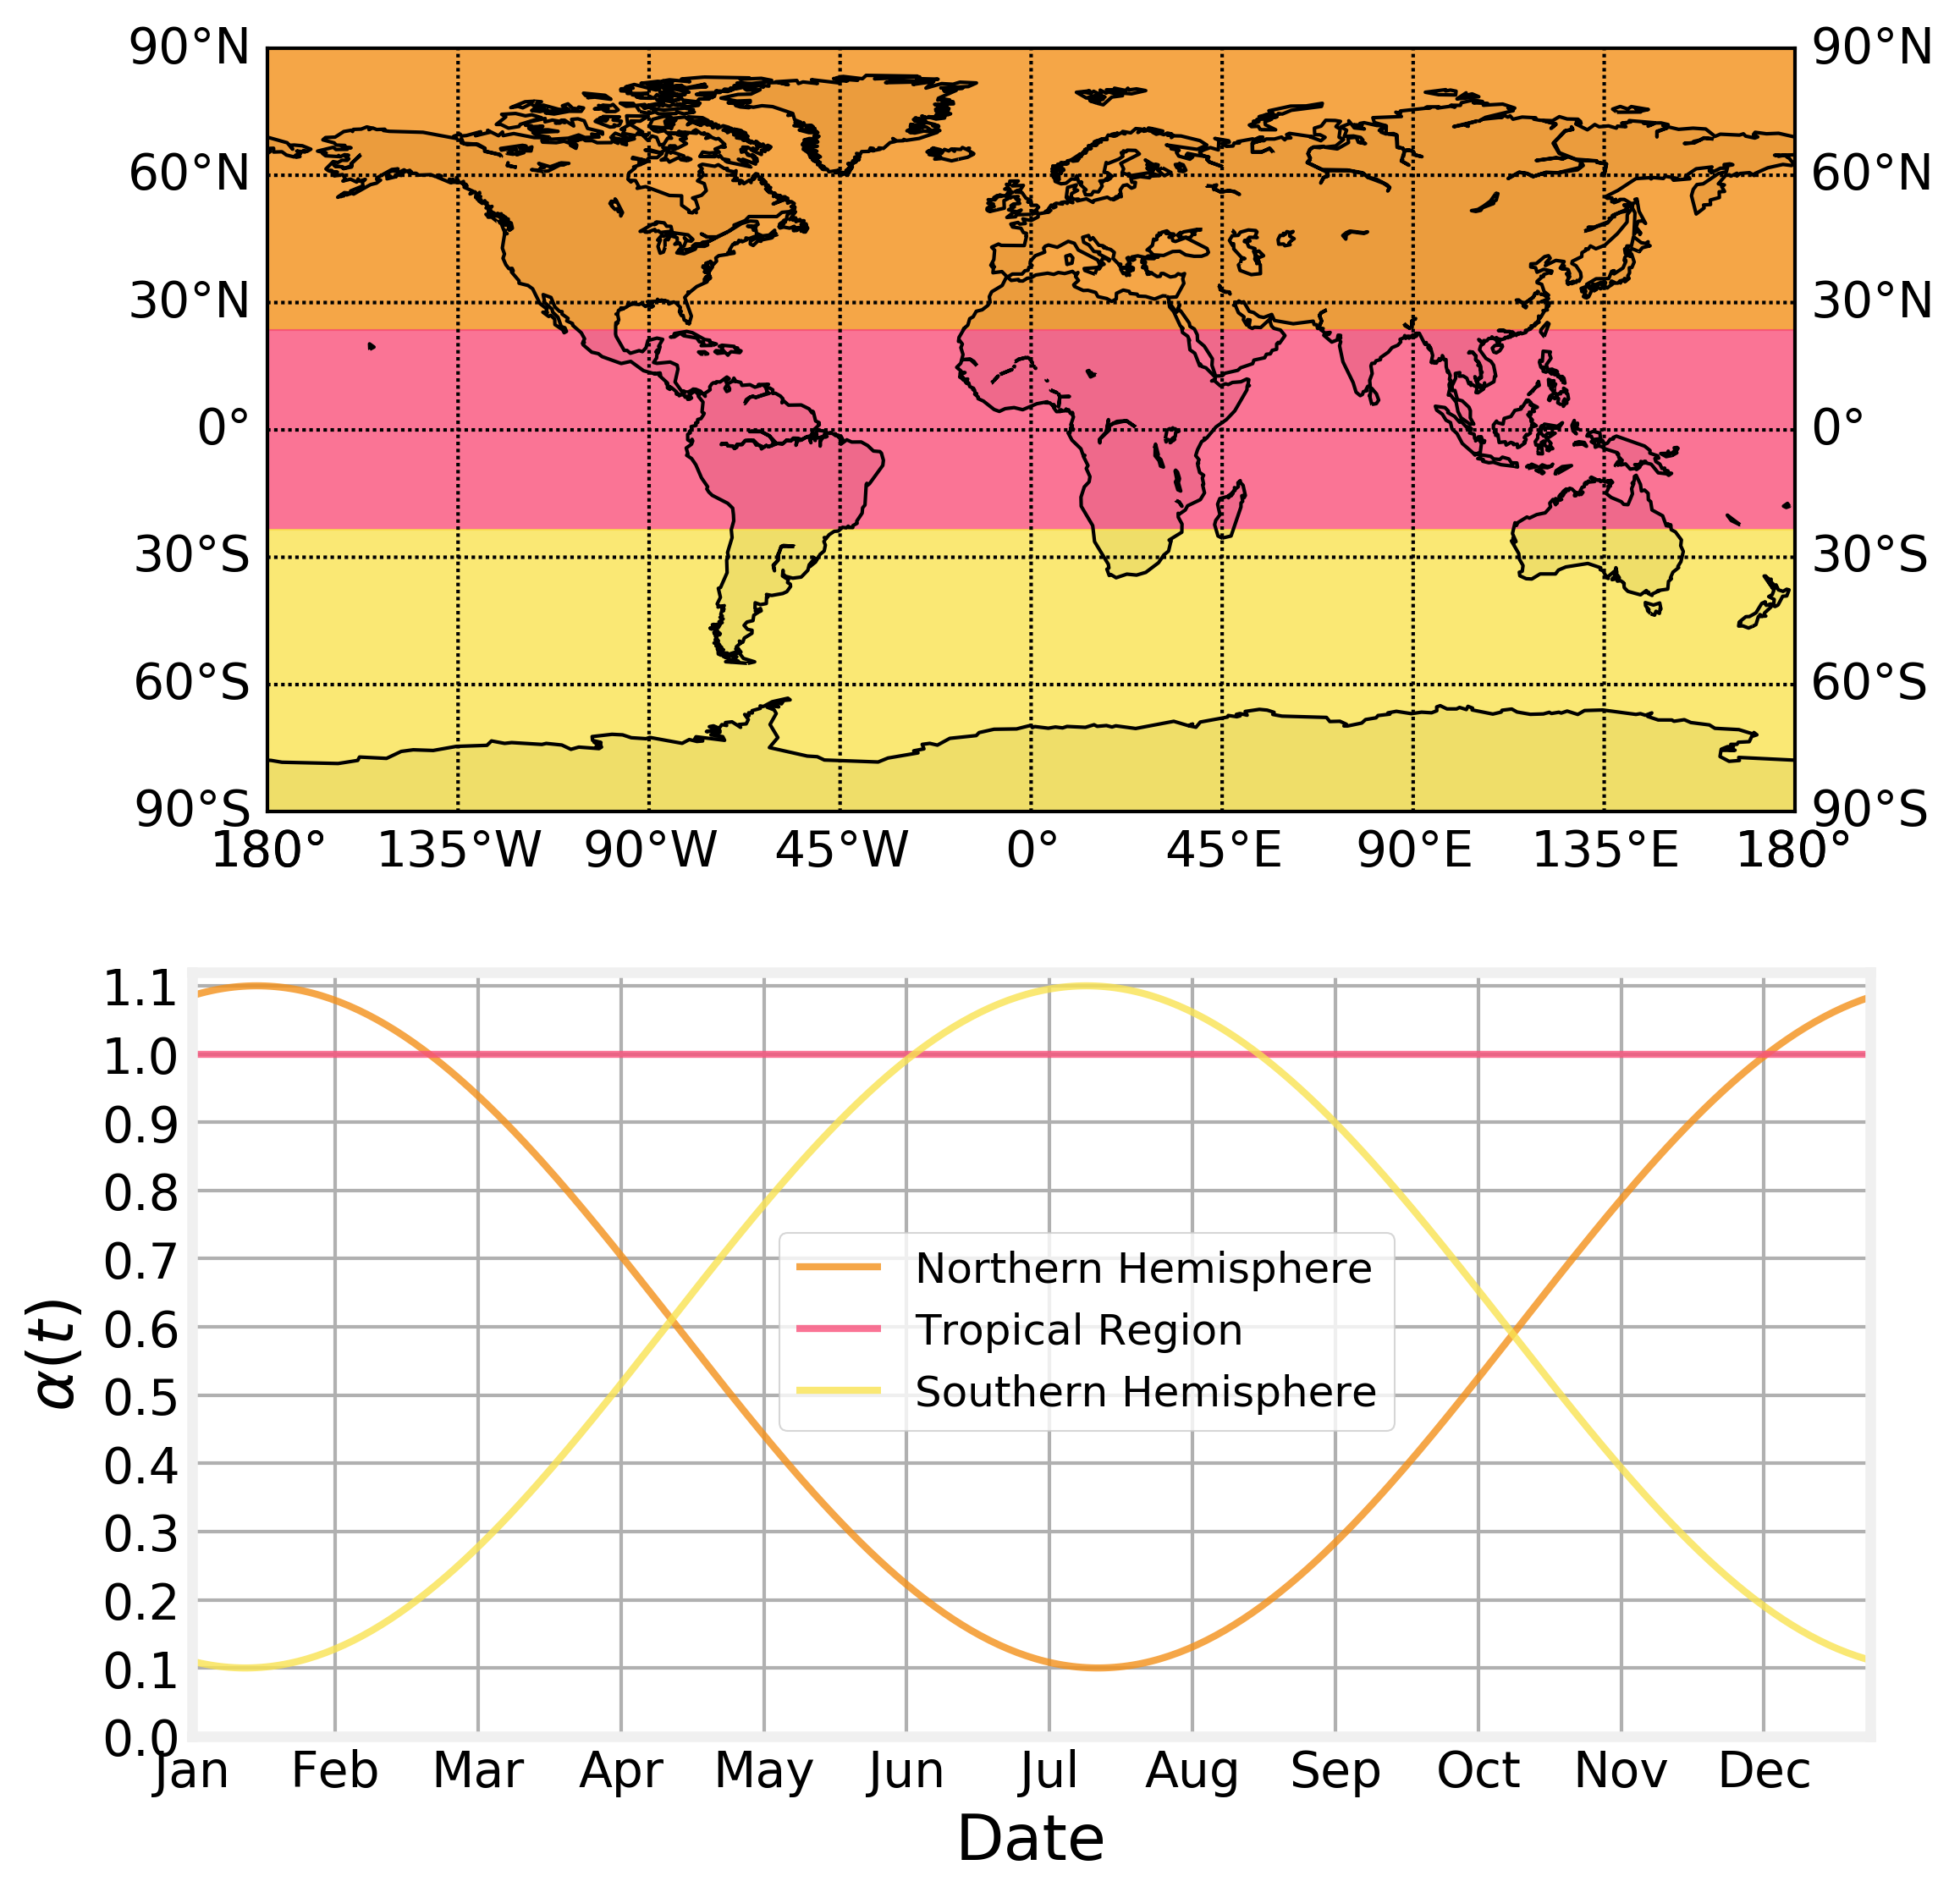

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(8,8))
m = Basemap(ax=ax[0])
m.drawmapboundary()
m.fillcontinents()
m.drawcoastlines()

ax[0].axhspan(xmin=-180, xmax=180, ymin=23.5, ymax=90, color=colors[3], alpha=.8, label='Northern Hemisphere')
ax[0].axhspan(xmin=-180, xmax=180, ymin=-23.5, ymax=23.5, color=colors[5], alpha=.8, label='Tropical Region')
ax[0].axhspan(xmin=-180, xmax=180, ymin=-90, ymax=-23.5, color=colors[4], alpha=.8, label='Southern Hemisphere')

m.drawparallels(np.arange(-90, 90.5, 30), labels=[1,1,0,1], fontsize=14)
m.drawmeridians(np.arange(-180, 180, 45), labels=[1,1,0,1], fontsize=14)

dates = pd.date_range('2019-01-01', '2019-12-31')
date_labels = [date.strftime("%b") for date in dates]

ax[1].plot(dates, seasonality(), label='Northern Hemisphere', c=colors[3], alpha=0.8, lw=2)
ax[1].plot(dates, np.ones(365), label='Tropical Region', c=colors[5], alpha=0.8, lw=2)
ax[1].plot(dates, seasonality(t_max=195), label='Southern Hemisphere', c=colors[4], alpha=0.8, lw=2)

ax[1].set_xticks(dates[0::31], False)
ax[1].set_xticklabels(date_labels[::31], fontsize=14)
ax[1].set_xlabel('Date', fontsize=18)
ax[1].set_ylabel(r'$\alpha\left(t\right)$', fontsize=18)
ax[1].set_xlim(dates[0], dates[-1])
ax[1].set_ylim(0, 1.12)
ax[1].set_yticks(np.arange(0, 1.11, 0.1))
ax[1].set_yticklabels(np.around(np.arange(0, 1.11, 0.1), 1), fontsize=14)
ax[1].legend(loc=(0.35, 0.4), fontsize=12)
fig.tight_layout()

## CoVID19 Model

As before, we start by considering the simple SIR model as it is easy to understand and it contains enough features for our purposes 

In [11]:
mu = 0.1
pD = 0.10

rbeta = 0.75
pa = 0.4
epsilon = 0.4
R0 = 2.0

beta = R0*mu/(pa*rbeta+(1-pa))

SEIIRD = EpiModel()
SEIIRD.add_interaction('S', 'E', 'Ia', rbeta*beta)
SEIIRD.add_interaction('S', 'E', 'Is', beta)
SEIIRD.add_spontaneous('E', 'Ia', epsilon*pa)
SEIIRD.add_spontaneous('E', 'Is', epsilon*(1-pa))
SEIIRD.add_spontaneous('Ia', 'R', mu)
SEIIRD.add_spontaneous('Is', 'R', (1-pD)*mu)
SEIIRD.add_spontaneous('Is', 'D', pD*mu)

In [12]:
print(SEIIRD)

Epidemic Model with 6 compartments and 7 transitions:

S + Ia = E 0.166667
S + Is = E 0.222222
E -> Ia 0.160000
E -> Is 0.240000
Ia -> R 0.100000
Is -> R 0.090000
Is -> D 0.010000

R0=2.00


In [13]:
N = 100000
I0 = 10

In [14]:
SEIIRD.integrate(365, S=N-I0, Ia=0, Is=I0, E=0, R=0, D=0)

non_seasonal = SEIIRD.values_.copy()

Text(0, 0.5, 'Population')

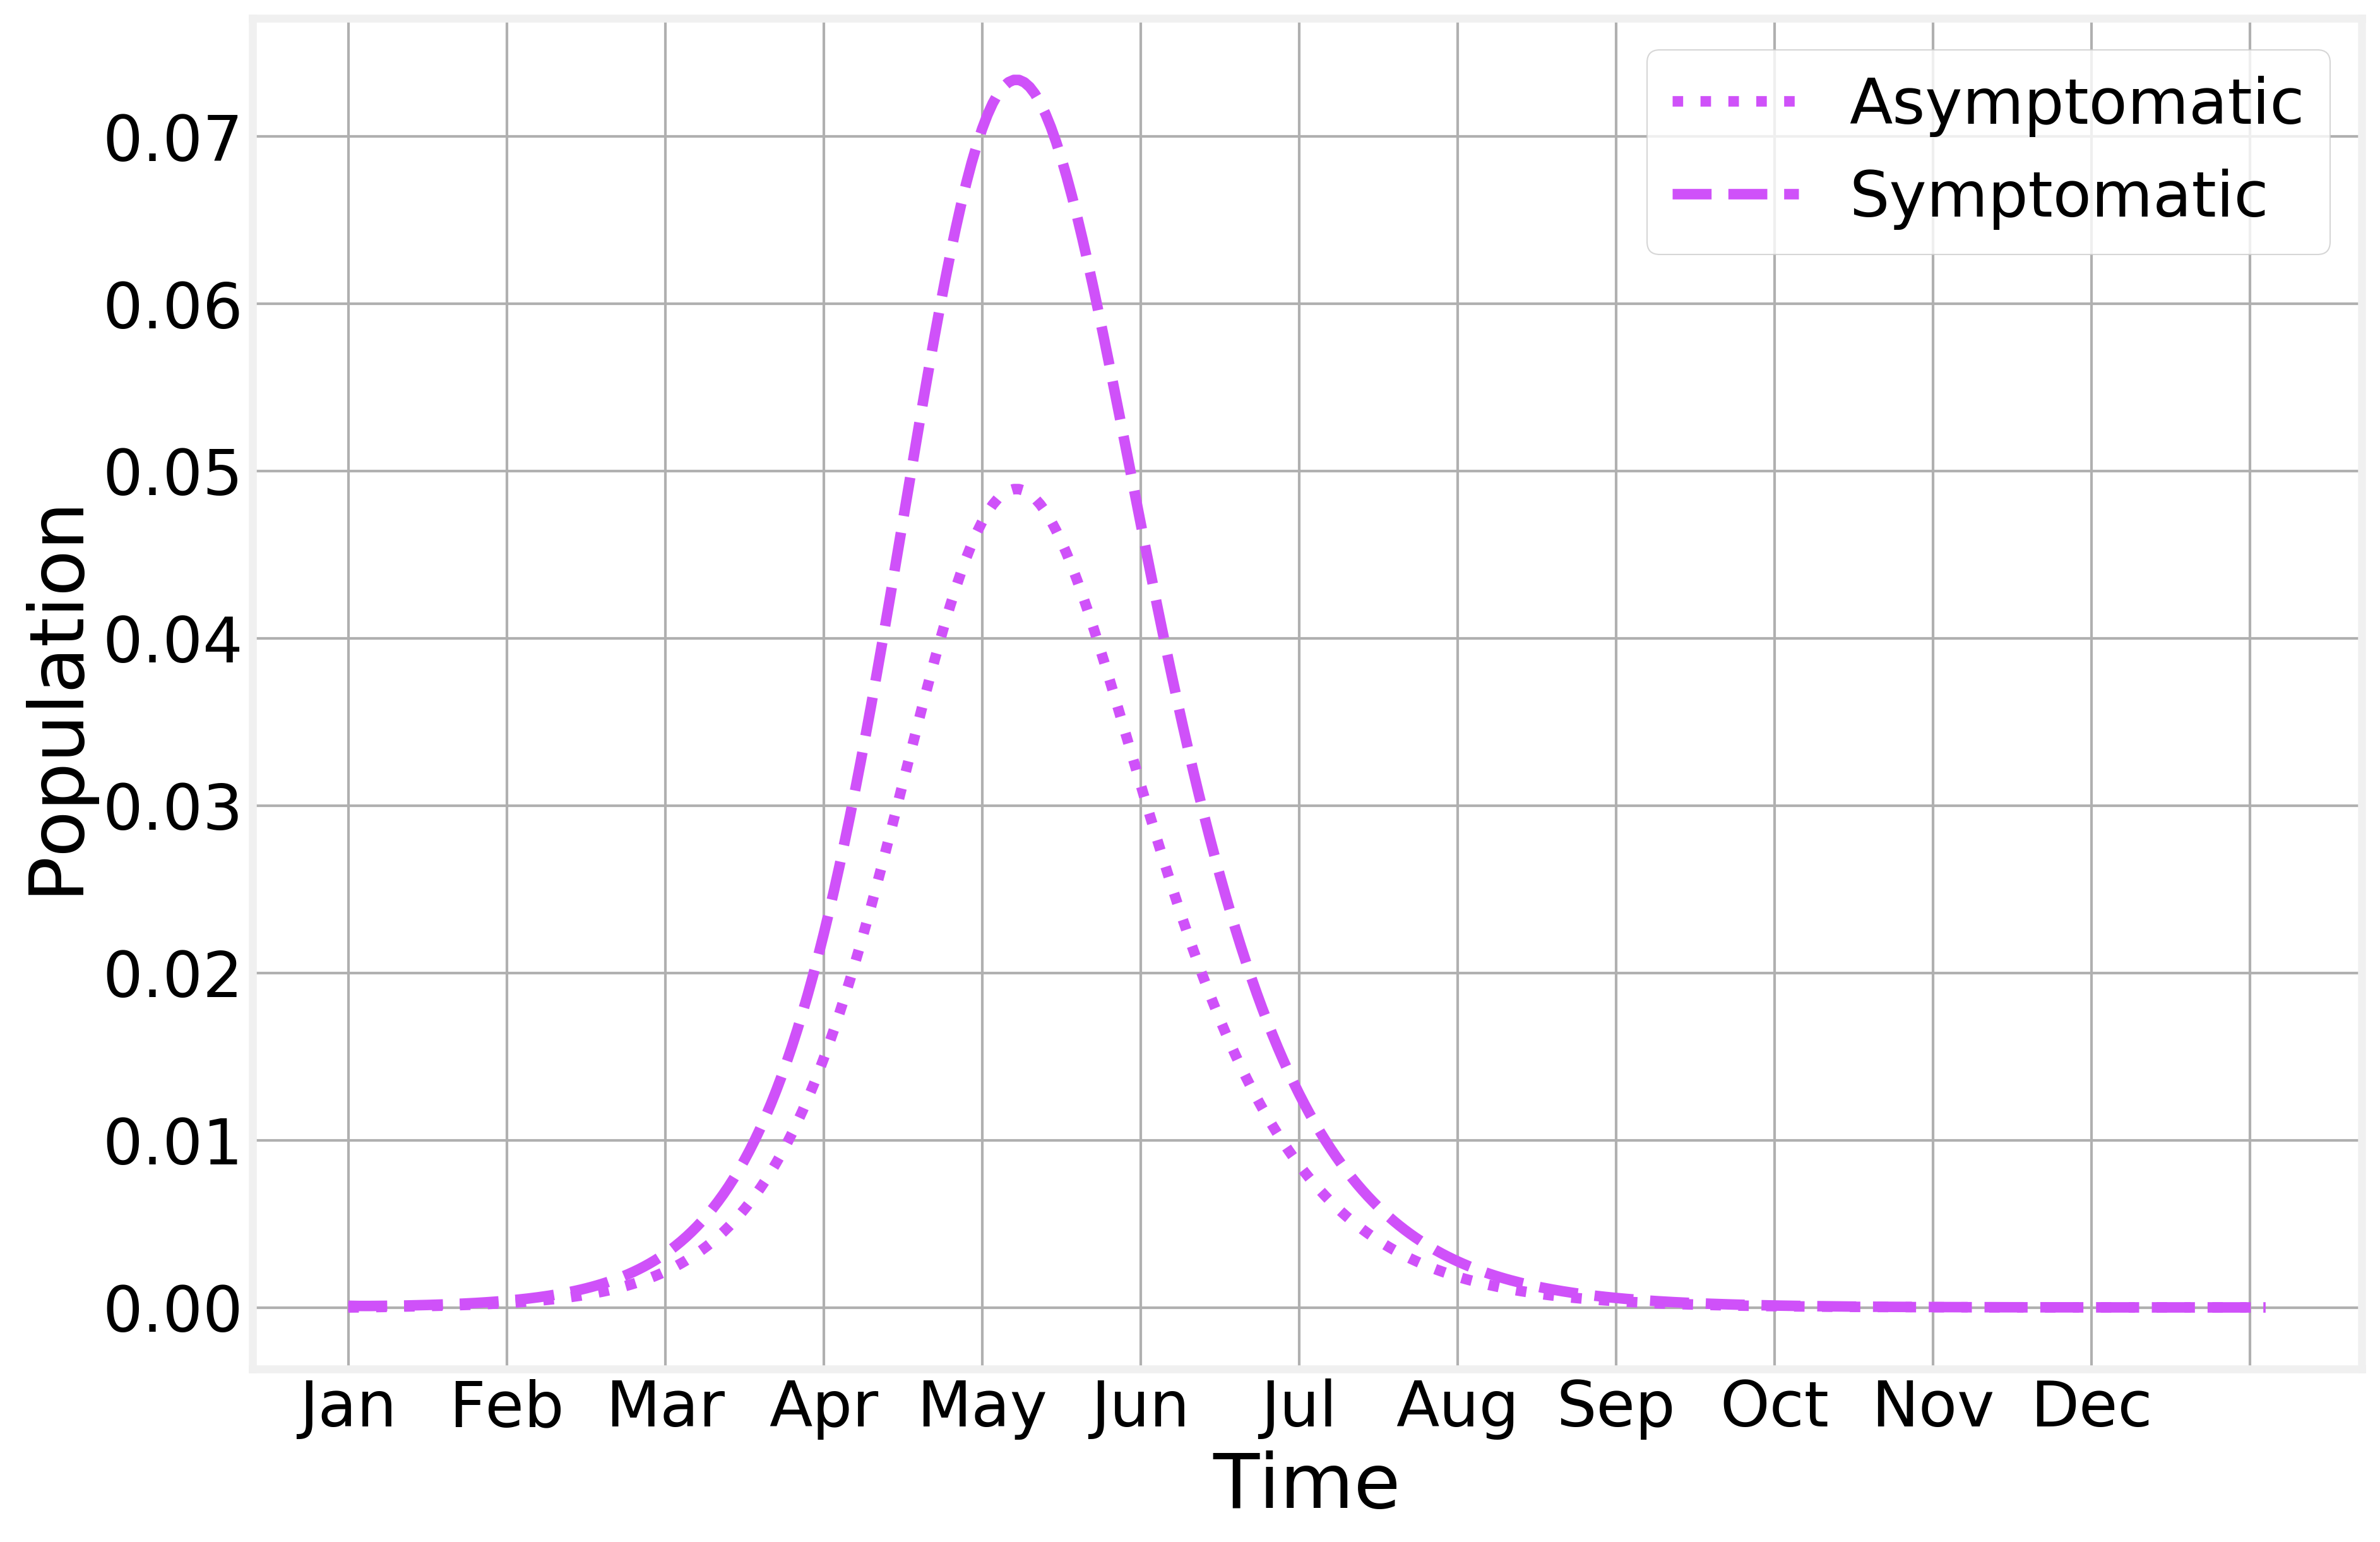

In [29]:
fig, ax = plt.subplots(1)
#(non_seasonal.S/N).plot(color=colors[0], linestyle='-', label='Susceptible', ax=ax)
#(non_seasonal.E/N).plot(color=colors[4], linestyle='-', label='Exposed', ax=ax)
(non_seasonal.Ia/N).plot(color=colors[1], linestyle=':', label='Asymptomatic', ax=ax)
(non_seasonal.Is/N).plot(color=colors[1], linestyle='--', label='Symptomatic', ax=ax)
#(non_seasonal.R/N).plot(color=colors[2], linestyle='-', label='Recovered', ax=ax)
#(non_seasonal.D/N).plot(color=colors[7], linestyle='-', label='Dead', ax=ax)

ax.set_xticks(np.arange(1, 366, 30))
ax.set_xticklabels(date_labels[::31])
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Population')

In [25]:
SEIIRD.integrate(365, seasonality=seasonality(t_max=195), S=N-I0, Ia=0, Is=I0, E=0, R=0, D=0)
seasonal = SEIIRD.values_.copy()

Text(0, 0.5, 'Population')

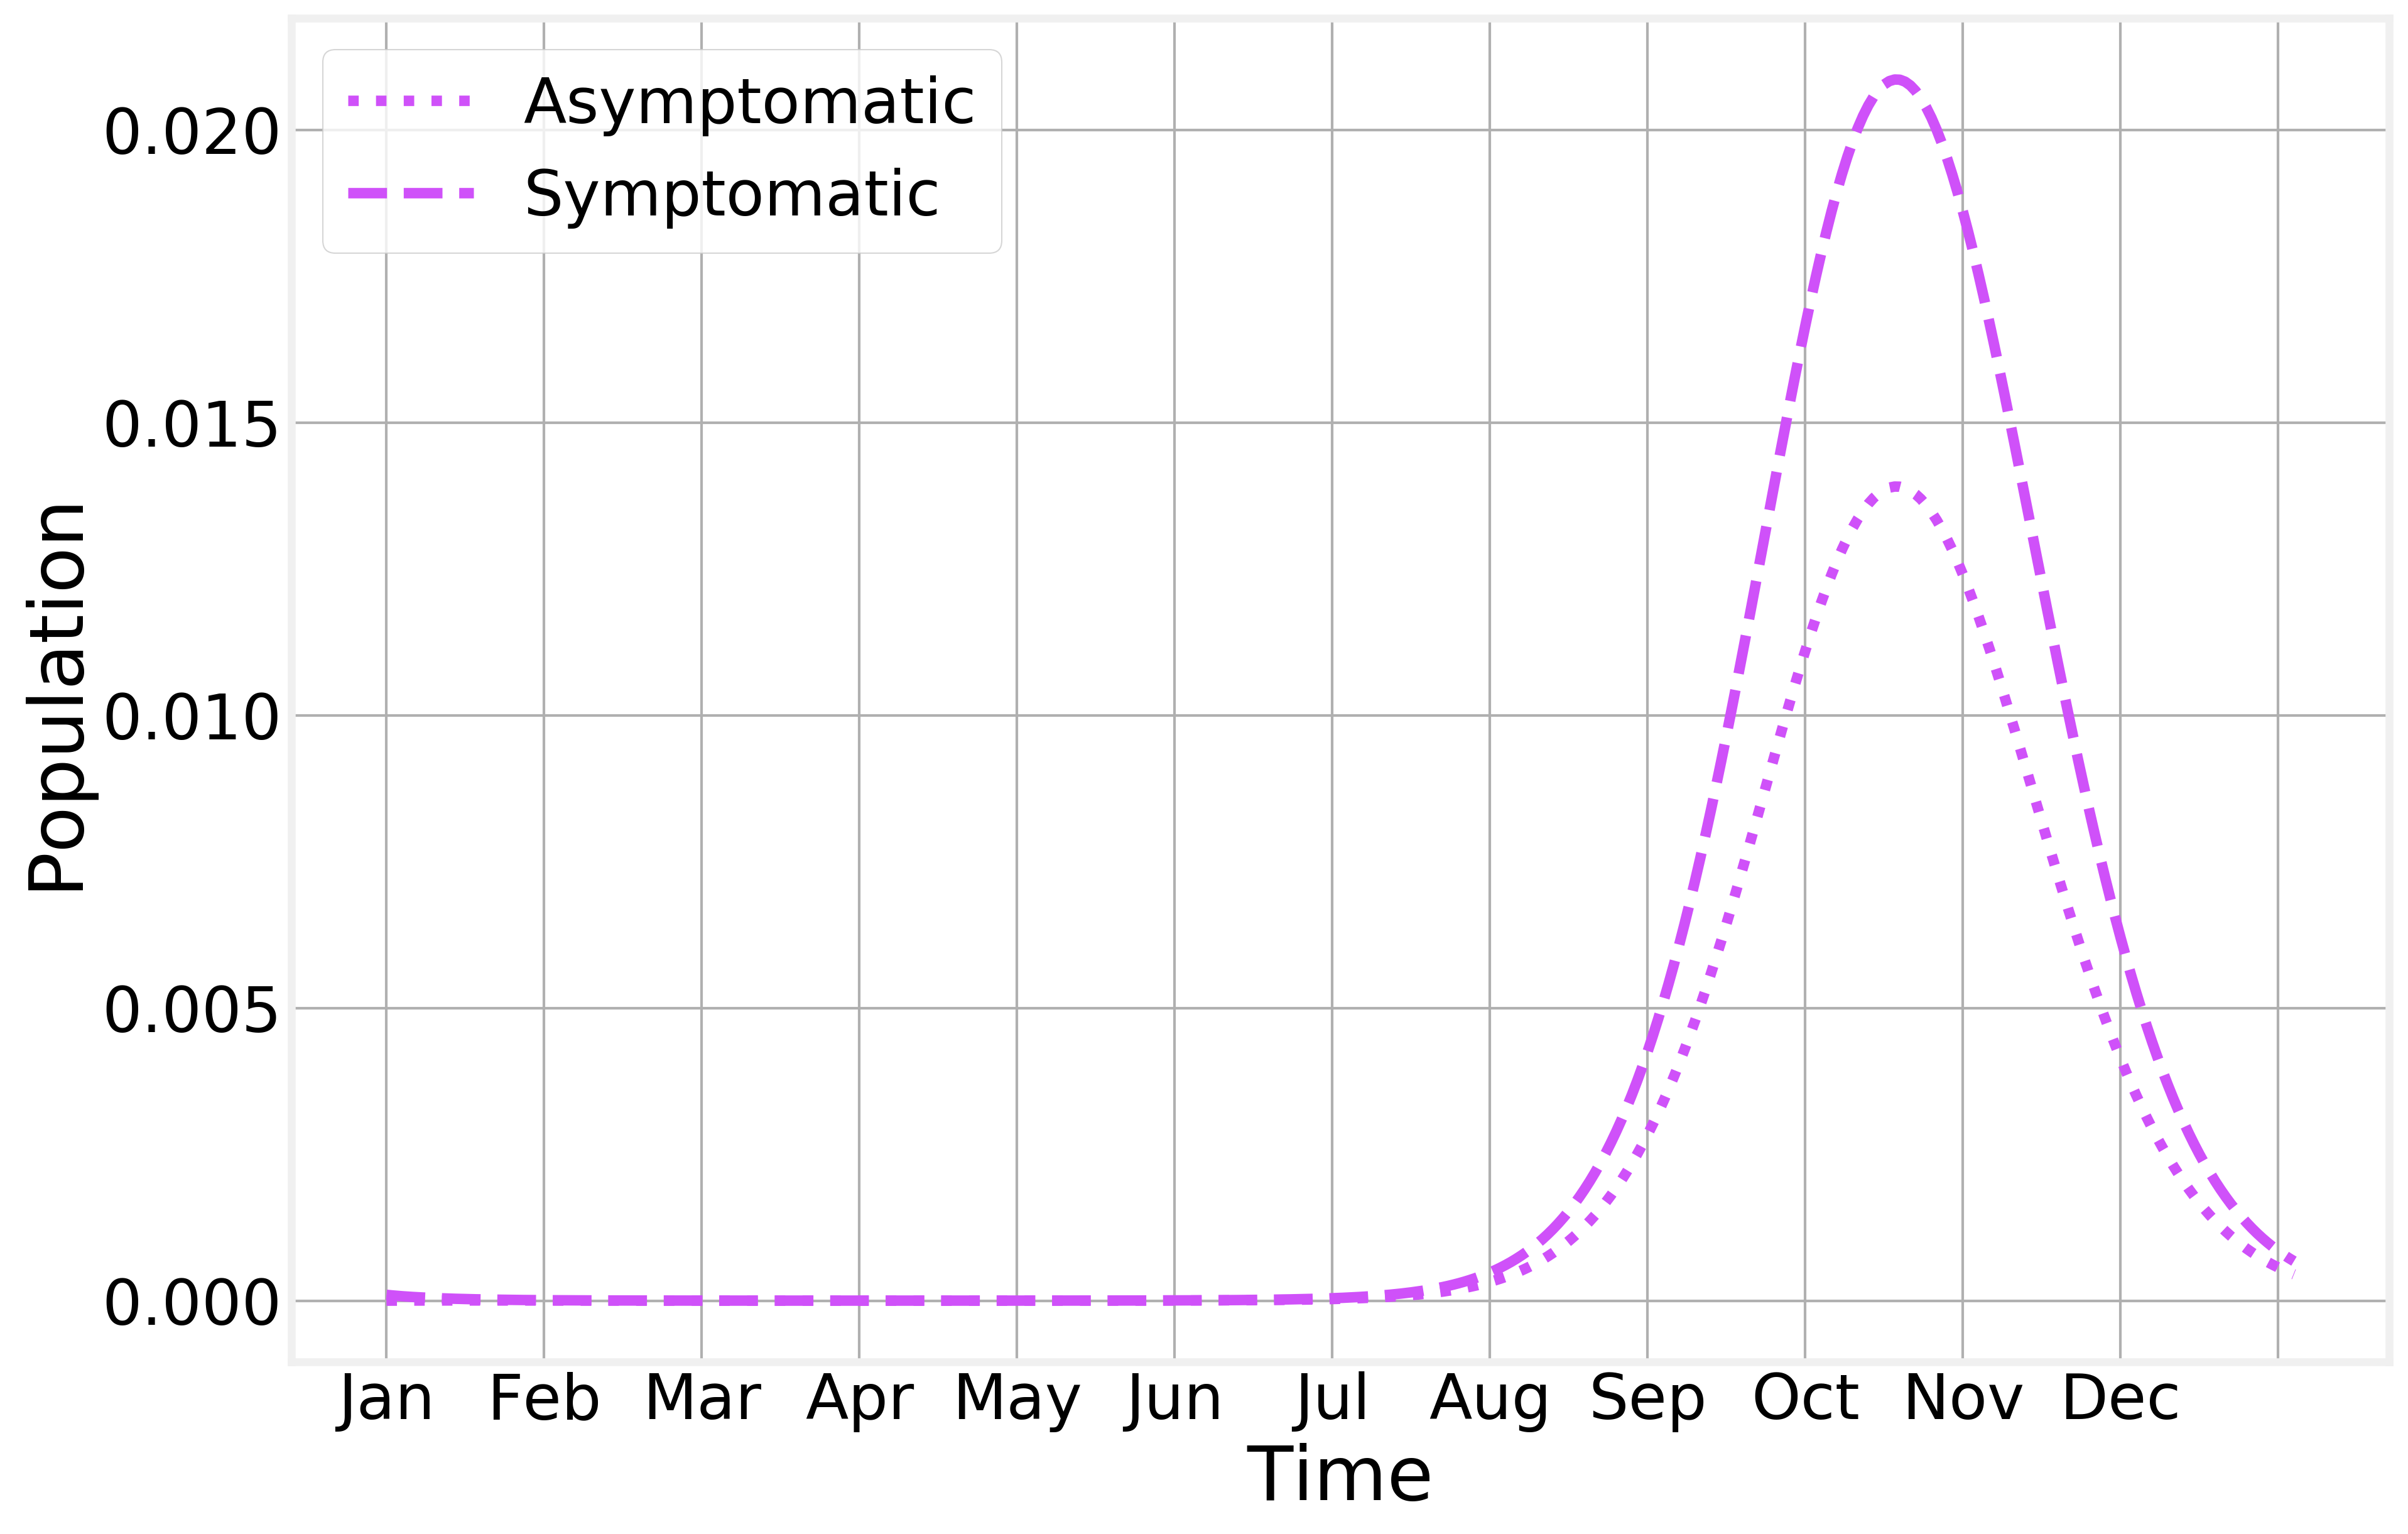

In [30]:
fig, ax = plt.subplots(1)
#(seasonal.S/N).plot(color=colors[0], linestyle='-', label='Susceptible', ax=ax)
#(seasonal.E/N).plot(color=colors[4], linestyle='-', label='Exposed', ax=ax)
(seasonal.Ia/N).plot(color=colors[1], linestyle=':', label='Asymptomatic', ax=ax)
(seasonal.Is/N).plot(color=colors[1], linestyle='--', label='Symptomatic', ax=ax)
#(seasonal.R/N).plot(color=colors[2], linestyle='-', label='Recovered', ax=ax)
#(seasonal.D/N).plot(color=colors[7], linestyle='-', label='Dead', ax=ax)

ax.set_xticks(np.arange(1, 366, 30))
ax.set_xticklabels(date_labels[::31])

ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Population')

In [33]:
seasonal['Is'].values

array([1.00000000e+01, 9.07197319e+00, 8.26489577e+00, 7.55256820e+00,
       6.91669902e+00, 6.34423858e+00, 5.82563644e+00, 5.35370025e+00,
       4.92284689e+00, 4.52860814e+00, 4.16730549e+00, 3.83583184e+00,
       3.53150620e+00, 3.25197429e+00, 2.99514104e+00, 2.75912258e+00,
       2.54221209e+00, 2.34285509e+00, 2.15962999e+00, 1.99123369e+00,
       1.83646928e+00, 1.69423621e+00, 1.56352202e+00, 1.44339464e+00,
       1.33299628e+00, 1.23153684e+00, 1.13828952e+00, 1.05258530e+00,
       9.73808741e-01, 9.01393599e-01, 8.34819344e-01, 7.73607484e-01,
       7.17318202e-01, 6.65547509e-01, 6.17924359e-01, 5.74108031e-01,
       5.33785783e-01, 4.96670596e-01, 4.62499177e-01, 4.31029791e-01,
       4.02040932e-01, 3.75329429e-01, 3.50708984e-01, 3.28008826e-01,
       3.07072410e-01, 2.87756259e-01, 2.69928924e-01, 2.53469809e-01,
       2.38268553e-01, 2.24223998e-01, 2.11243378e-01, 1.99241762e-01,
       1.88141317e-01, 1.77870713e-01, 1.68364589e-01, 1.59563055e-01,
      

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>